In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import math
import os
import random

import matplotlib.pyplot as plt
plt.rc('font', family='Helvetica')

In [2]:
def get_vid_df(exp_name, time_offset=-1, interval=500):
    
    if interval < 500:
        interval = 500
    div = int(interval / 500)
    
    with open(f'log_video_{exp_name}') as file:

        rows = []

        for line in file.readlines():
            line = line.strip().split('\t')
            vid_data = json.loads(line[7])
            
            for vid_log in vid_data:
                
                if next((row for row in rows if row[0] == vid_log['logCount']), None) == None:
                    
                    if vid_log['logCount'] == 0:
                        row = []
                        row.append(vid_log['logCount'])
                        row.append(vid_log['timeStamp'])
                        row.append(vid_log['timeElapsed'])
                        row.append(vid_log['totalFrames'])
                        row.append(vid_log['droppedFrames'])
                        row.append(vid_log['frameRate'])
                        row.append(vid_log['droppedFrames'])
                        row.append(instEncodedFrames := vid_log['totalFrames'])
                        row.append(encodedFPS := 0)
                        rows.append(row)
                    elif int(vid_log['logCount']) % div == 0:
                        row = []
                        row.append(vid_log['logCount'])
                        row.append(vid_log['timeStamp'])
                        row.append(vid_log['timeElapsed'])
                        row.append(vid_log['totalFrames'])
                        row.append(vid_log['droppedFrames'])
                        prevTimeElapsed = rows[-1][2]
                        prevTotalFrames = rows[-1][3]
                        prevDroppedFrames = rows[-1][4]
                        frameRate = ((vid_log['totalFrames'] - prevTotalFrames) - (vid_log['droppedFrames'] - prevDroppedFrames)) / (vid_log['timeElapsed'] - prevTimeElapsed)
                        row.append(frameRate)
                        try:
                            instFrameLoss = (vid_log['droppedFrames'] - prevDroppedFrames) / (vid_log['totalFrames'] - prevTotalFrames)
                        except ZeroDivisionError:
                            instFrameLoss = 0
                        instFrameLoss *= 100
                        row.append(instFrameLoss)
                        instEncodedFrames = vid_log['totalFrames'] - prevTotalFrames
                        encodedFPS = instEncodedFrames / (vid_log['timeElapsed'] - prevTimeElapsed)
                        row += [instEncodedFrames, encodedFPS]
                        rows.append(row)
                        
    vid_df = pd.DataFrame(rows, columns=['logCount', 'Time', 'timeElapsed', 'totalFrames', 'droppedFrames', 'Frame Rate', 'instFrameLoss', 'instEncodedFrames', 'encodedFPS'])
    vid_start_time_in_s = vid_df.iloc[0]['Time']/1000
    vid_df['Time'] = (vid_df['Time'] - vid_df.iloc[0]['Time'])/1000 if time_offset == -1 else vid_df['Time']/1000 - time_offset
    vid_df['timeElapsed'] = vid_df['timeElapsed'] - vid_df.iloc[0]['timeElapsed']

    return vid_df, vid_start_time_in_s

In [3]:
# (\d+\.\d+\s+\d{2}-\d{2}\s+\d+:\d+:\d+\.\d+\s+\d{3}\s+\d+\s+I\s+ActivityManager:)

from datetime import datetime 

def get_utc_time(date, time) -> float:
    
    datetime_str = f'{date} 2022 {time}000 +0500'
    # datetime_str = '06-03 2022 21:08:52.505000 +0500'

    datetime_object = datetime.strptime(datetime_str, '%m-%d %Y %H:%M:%S.%f %z')
    
    return datetime_object.timestamp()

def get_device_stats(exp_name, start_time):

    with open(f'logcat_{exp_name}') as file:

        rows = []

        for line in file.readlines():
            if "ActivityManager" in line and "has died" in line:
                line = line.strip().split()
                time = get_utc_time(line[0], line[1])
                rows.append([time, line[7]])
            
    df_logcat = pd.DataFrame(rows, columns=['time', 'Process Name'])

    # df_logcat = df_logcat[df_logcat['time'] >= (start_time - 10)]
    df_logcat['time'] = df_logcat['time'] - start_time

    return df_logcat

In [4]:
# (\d+\.\d+\s+\d{2}-\d{2}\s+\d+:\d+:\d+\.\d+\s+\d{3}\s+\d+\s+I\s+ActivityManager:)

def get_mem_stats(exp_name, start_time):

    rows = []

    for file_name in os.listdir(f'memstats_{exp_name}'):

        if file_name == 'vid_time':
            continue
        
        with open(f'memstats_{exp_name}/{file_name}') as file:

            lines = list(file.readlines())

            log_time = float(lines[0].split()[1])
            mem_free = float(lines[2].split()[1])/1000
            mem_total = float(lines[0].split()[1])/1000
            mem_available = float(lines[3].split()[1])/1000
            mem_cached = float(lines[5].split()[1])/1000
            mem_active = float(lines[7].split()[1])/1000
            mem_inactive = float(lines[8].split()[1])/1000
            mem_active_cached = mem_active + mem_cached
            num_active_processes = len(lines) - 44

            rows.append([log_time, mem_free, mem_total, mem_available, mem_cached, mem_active, \
                mem_inactive, mem_active_cached, num_active_processes])

    df_mem = pd.DataFrame(rows, columns=['time', 'mem_free', 'mem_total', \
        'mem_available', 'mem_cached', 'mem_active', 'mem_inactive', 'mem_active_cached', 'num_active_processes'])

    # df_mem = df_mem[df_mem['time'] >= (start_time - 10)]
    df_mem['time'] = df_mem['time'] - start_time

    return df_mem.sort_values(by=['time'], ignore_index=True)

In [5]:
def get_press_enter_time(exp_name: str) -> float:
    
    file_name = 'vid_time'
    
    with open(f'memstats_{exp_name}/{file_name}') as file:
        press_enter_time = float(file.read().strip().split()[-1])
    
    return press_enter_time
    

In [6]:
def plot_all_graphs(vid_df, df_device, df_mem, time_start, time_end, title):
    
    _, (ax, ax3, ax2) = plt.subplots(3, 1, figsize=(8, 8))

    sns.lineplot(ax=ax, data=vid_df, x='Time', y='Frame Rate', linestyle='-', marker='o')
    ax.set_xlabel('Time Elapsed (s)', fontsize=15)
    ax.set_ylabel("Frame Rate", fontsize=15)
    ax.set_title(title, fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=13)
    # ax.scatter(df_device["time"], [random.uniform(10.5, 50.5) for _ in range(len(df_device))], marker='x', color='red')
    # ax.grid()

    axtwin = ax3
    sns.lineplot(ax=axtwin, data=df_mem, x='time', y='mem_free', linestyle='-', label='Free Mem (MB)')
    sns.lineplot(ax=axtwin, data=df_mem, x='time', y='mem_available', linestyle='-', label='Available Mem (MB)')
    sns.lineplot(ax=axtwin, data=df_mem, x='time', y='mem_active', linestyle='-', label='Active Mem (MB)')
    sns.lineplot(ax=axtwin, data=df_mem, x='time', y='mem_cached', linestyle='-', label='Cached Mem (MB)')
    sns.lineplot(ax=axtwin, data=df_mem, x='time', y='mem_active_cached', linestyle='-', label='Active + Cached Mem (MB)')
    axtwin.set_ylim(0, 800)

    sns.histplot(data=df_device, ax=ax2, x="time", binwidth=1)
    ax2.set_ylim(0, 5)
    # ax2.set_xticks(range(0, 5))

    ax2twin = ax2.twinx()
    sns.lineplot(data=df_mem, ax=ax2twin, x="time", y="num_active_processes", color='r')
    ax2twin.set_ylim(350, 380)
    ax2twin.grid()

    x_lim = time_end

    ax.set_xlim(time_start, x_lim)
    axtwin.set_xlim(time_start, x_lim)
    ax2.set_xlim(time_start, x_lim)
    ax2twin.set_xlim(time_start, x_lim)

In [7]:
time_start, time_end = 0, 140

In [8]:
def plot_graph(vid_df, df_device, df_mem, time_start, time_end, title, color=None):
    
    _, (ax, ax2) = plt.subplots(2, 1, figsize=(9, 4), gridspec_kw={'height_ratios': [2, 1]})

    sns.lineplot(ax=ax, data=vid_df, x='Time', y='Frame Rate', linestyle='-')
    ax.set_xlabel('', fontsize=13)
    ax.set_ylabel("Rendered FPS ($s^{-1}$)", fontsize=13)
    ax.set_title(title, fontsize=15)
    ax.set_yticks(range(0, 60+1, 10))
    ax.set_xticks(range(time_start, time_end+1, 10))
    ax.tick_params(axis='both', which='major', labelsize=13)
    # ax.scatter(df_device["time"], [random.uniform(10.5, 50.5) for _ in range(len(df_device))], marker='x', color='red')
    ax.grid(linestyle='--')

    # axtwin = ax.twinx()
    # sns.lineplot(ax=axtwin, data=df_mem, x='time', y='mem_free', linestyle='-', color='k', label='Free Mem (MB)')
    # sns.lineplot(ax=axtwin, data=df_mem, x='time', y='mem_available', linestyle='-', color='cyan', label='Available Mem (MB)')
    # axtwin.set_ylim(0, 500)

    sns.histplot(data=df_device, ax=ax2, x="time", binwidth=1, color='red')
    ax2.set_ylim(0, 3.2)
    ax2.set_xlabel('Time Elapsed (s)', fontsize=13)
    ax2.set_ylabel("No. of Proc-\nesses Killed", fontsize=13)
    ax2.tick_params(axis='both', which='major', labelsize=13)
    ax2.set_xticks(range(time_start, time_end+1, 10))
    ax2.set_yticks(range(0, 3+1))
    ax2.grid(linestyle='--')
    # ax2.set_xticks(range(0, 5))

    # ax2twin = ax2.twinx()
    # sns.lineplot(data=df_mem, ax=ax2twin, x="time", y="num_active_processes", color='r')
    # ax2twin.set_ylim(350, 380)
    # ax2twin.grid()

    x_lim = time_end

    ax.set_xlim(time_start, x_lim)
    # axtwin.set_xlim(time_start, x_lim)
    ax2.set_xlim(time_start, x_lim)
    # ax2twin.set_xlim(time_start, x_lim)

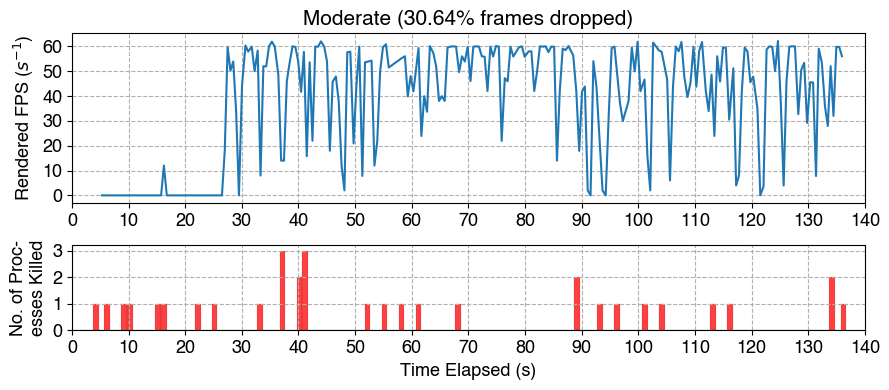

In [9]:
exp_name = 'dubai_60fps480p_m'
press_enter_time = get_press_enter_time(exp_name)
df, _ = get_vid_df(exp_name, time_offset=press_enter_time)
df_device = get_device_stats(exp_name, press_enter_time)
df_mem = get_mem_stats(exp_name, press_enter_time)
df_device_m = df_device
df_mem_m = df_mem

df['%_dropped'] = (df['droppedFrames'] / df['totalFrames']) * 100
dropped = df.iloc[time_end*2 if time_end*2 <= len(df) else -1]['%_dropped']
# print('% dropped:', dropped)

plot_graph(df, df_device, df_mem, time_start, time_end, f'Moderate ({dropped:.2f}% frames dropped)')
plt.tight_layout()
plt.savefig('moderate.jpg', dpi=200, bbox_inches='tight')

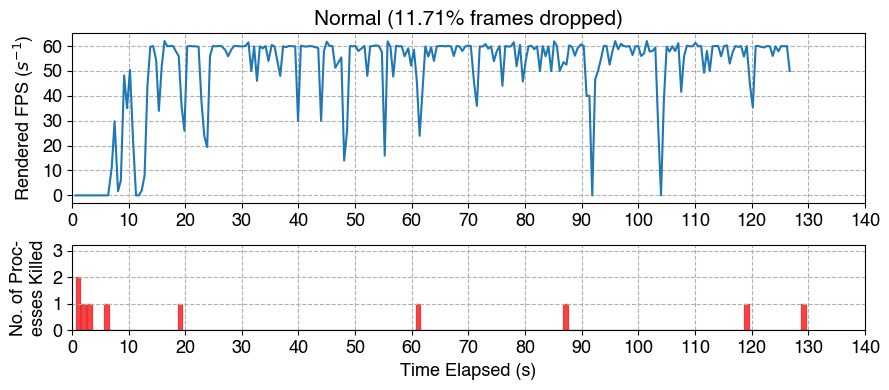

In [10]:
exp_name = 'dubai_60fps480p_n'
press_enter_time = get_press_enter_time(exp_name)
df, _ = get_vid_df(exp_name, time_offset=press_enter_time)
df_device = get_device_stats(exp_name, press_enter_time)
df_mem = get_mem_stats(exp_name, press_enter_time)
df_device_n = df_device
df_mem_n = df_mem

df['%_dropped'] = (df['droppedFrames'] / df['totalFrames']) * 100
dropped = df.iloc[time_end*2 if time_end*2 <= len(df) else -1]['%_dropped']
# print('% dropped:', dropped)

plot_graph(df, df_device, df_mem, time_start, time_end, f'Normal ({dropped:.2f}% frames dropped)')
plt.tight_layout()
plt.savefig('normal.jpg', dpi=200, bbox_inches='tight')

In [ ]:
!convert -append normal.jpg moderate.jpg normal_moderate.jpg